In [3]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Customer Purchase Patterns") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
import pandas as pd

# Specify the path to your Excel file
excel_file = "/content/online_retail_II.xlsx"

# Read the Excel file
df = pd.read_excel(excel_file)

# Specify the path for the output CSV file
csv_file = "output_file.csv"

# Save the DataFrame as a CSV file
df.to_csv(csv_file, index=False)

print(f"Excel file has been converted to CSV and saved as {csv_file}")

# Load the dataset (update path as needed)
data_path = "/content/output_file.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Display data
df.show(5)


Excel file has been converted to CSV and saved as output_file.csv
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
only sh

In [5]:
# Select relevant columns (e.g., InvoiceNo and Description for transactions)
df = df.select("Invoice", "Description").dropna()

# Group items by InvoiceNo (transactional format for FP-Growth)
from pyspark.sql.functions import collect_list

transactions = df.groupBy("Invoice").agg(collect_list("Description").alias("items"))
transactions.show(5, truncate=False)


+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Invoice|items                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [7]:
transactions.show(5, truncate=False)


+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Invoice|items                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [8]:
from pyspark.sql.functions import collect_list

transactions = df.groupBy("Invoice").agg(collect_list("Description").alias("items"))


In [9]:
transactions.count()


25888

In [11]:
from pyspark.sql.functions import size

# Filter out rows where items column is empty
transactions = transactions.filter(size(transactions.items) > 0)

transactions.show(5, truncate=False)



+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Invoice|items                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [12]:
fp_growth = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0.1)


In [15]:
from pyspark.sql.functions import collect_list, array_distinct
from pyspark.ml.fpm import FPGrowth

# Group items by InvoiceNo (transactional format for FP-Growth)
# and remove duplicate items using array_distinct
transactions = df.groupBy("Invoice").agg(array_distinct(collect_list("Description")).alias("items"))

# Filter out rows where items column is empty
transactions = transactions.filter(size(transactions.items) > 0)

# Initialize FP-Growth model
fp_growth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.3)
model = fp_growth.fit(transactions)

# Frequent itemsets
frequent_itemsets = model.freqItemsets
frequent_itemsets.show()

# Association rules
association_rules = model.associationRules
association_rules.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
| [TOILET METAL SIGN]| 525|
|[TOILET METAL SIG...| 382|
|[POPPY'S PLAYHOUS...| 261|
|[SET 12 KIDS COLO...| 445|
|[EDWARDIAN PARASO...| 642|
|[WHITE WIRE EGG H...| 308|
|[SET OF 36 PAISLE...| 459|
|[SET OF 36 PAISLE...| 270|
|[LUNCH BOX WITH C...| 276|
|    [KEY FOB , SHED]| 478|
|[KITCHEN METAL SIGN]| 411|
|[KITCHEN METAL SI...| 297|
|[MINT KITCHEN SCA...| 315|
|[ROCKING HORSE RE...| 282|
| [RED SPOTTY PLATE ]| 290|
|[12 PENCILS SMALL...| 498|
|[SET OF 3 HEART C...| 597|
|[SET 10 LIGHTS NI...| 300|
|   [JUMBO BAG TOYS ]| 546|
|[CHOCOLATE BOX RI...| 268|
+--------------------+----+
only showing top 20 rows

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+------------

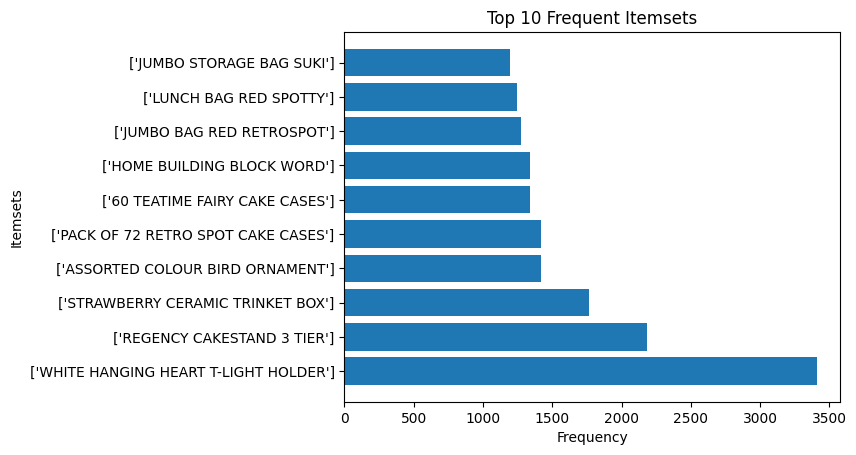

In [16]:
# Collect frequent itemsets and convert to Pandas for visualization
frequent_itemsets_pd = frequent_itemsets.toPandas()

import matplotlib.pyplot as plt

# Bar plot for top 10 frequent itemsets
top_itemsets = frequent_itemsets_pd.nlargest(10, "freq")
plt.barh(top_itemsets["items"].astype(str), top_itemsets["freq"])
plt.xlabel("Frequency")
plt.ylabel("Itemsets")
plt.title("Top 10 Frequent Itemsets")
plt.show()


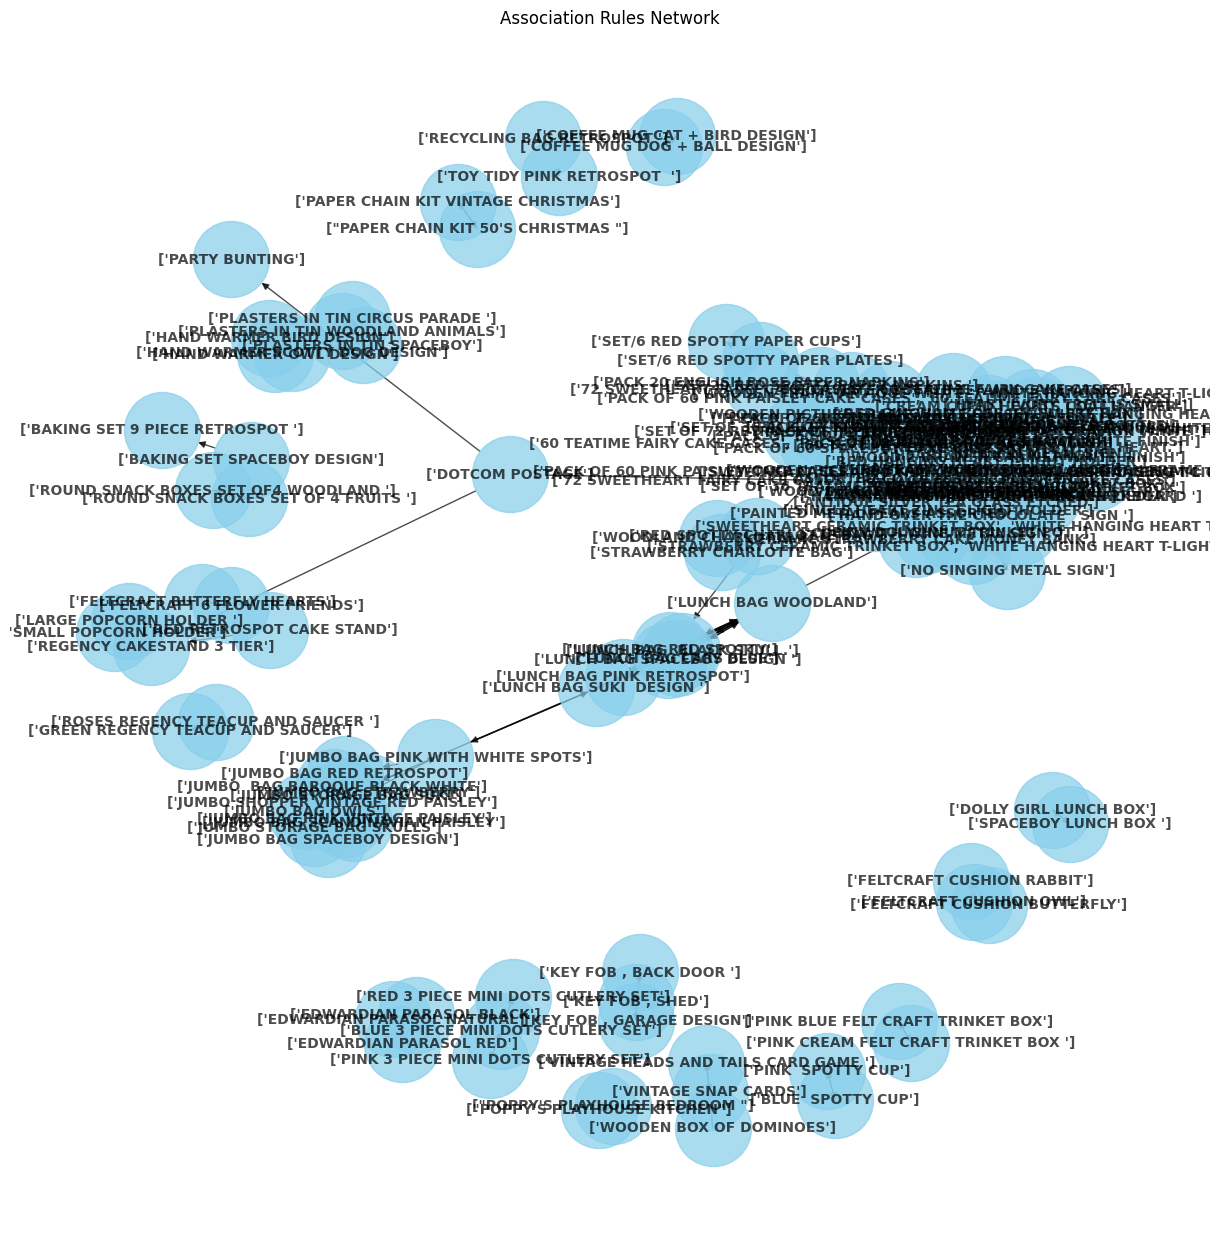

In [17]:
import networkx as nx

# Convert association rules to Pandas
association_rules_pd = association_rules.toPandas()

# Initialize a directed graph for the association rules
G = nx.DiGraph()

# Add nodes and edges from the association rules
for _, row in association_rules_pd.iterrows():
    G.add_edge(str(row['antecedent']), str(row['consequent']), weight=row['confidence'])

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True, font_weight='bold', node_size=3000, node_color='skyblue', font_size=10, alpha=0.7)
plt.title("Association Rules Network")
plt.show()
